In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pickle

In [3]:
train_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_images.pkl','rb'))
test_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_images.pkl','rb'))
TRAINING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TRAINING_LABELS.pkl','rb'))
TESTING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TESTING_LABELS.pkl','rb'))
train_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_masks.pkl','rb'))
test_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_masks.pkl','rb'))
train_borders=pickle.load(
    open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_borders.pkl','rb'))
test_borders=pickle.load(
    open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_borders.pkl','rb'))

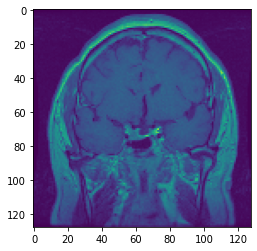

In [4]:
plt.imshow(np.array(train_images[0]).reshape(128,128))

In [5]:
from sklearn.preprocessing import LabelEncoder
TRAINING_LABELS['encoded_label']=LabelEncoder().fit_transform(TRAINING_LABELS['x_train'])

In [6]:
TRAINING_LABELS.head() 

,x_train,glioma Tumor,meningioma Tumor,pituitary Tumor,encoded_label
0,pituitary Tumor,0.0,0.0,1.0,2
1,pituitary Tumor,0.0,0.0,1.0,2
2,pituitary Tumor,0.0,0.0,1.0,2
3,meningioma Tumor,0.0,1.0,0.0,1
4,glioma Tumor,1.0,0.0,0.0,0


## Bayesian Squeeze and Excitation Learning with Approx KL Divergence

Squeeze and Excitation Block

In [23]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio, activation='relu')(x)
    x = keras.layers.Dense(ch, activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

KL Divergence

In [24]:
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / train_images.shape[0]
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / train_images.shape[0]

Architecture

In [25]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=tfp.layers.Convolution2DReparameterization(filters=128, kernel_size=16, activation='relu',
        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = Approx_divergence_fn,
        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn = Approx_divergence_fn)(Input_)

padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(padding_1,128)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(padding_2)
Attension_3=SE_BLOCK(Hidden_3,32)

Last_conv=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
padding_last=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Last_conv)

Flat=keras.layers.Flatten()(padding_last)

Dense_network=tfp.layers.DenseReparameterization(
    units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
output_1=tfp.layers.OneHotCategorical(3)(Dense_network)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [26]:
BI_Based_SE_Architecture_3=keras.models.Model([Input_],[output_1])

In [27]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))

BI_Based_SE_Architecture_3.compile(loss = negative_log_likelihood,
             optimizer = keras.optimizers.Adam(learning_rate=0.005),metrics = ['accuracy'])

In [28]:
hist=BI_Based_SE_Architecture_3.fit(
                   train_images,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values,
                   epochs=500)

Epoch 1/500
88/88 [==============================] - 6s 51ms/step - loss: 120.9063 - accuracy: 0.4750
Epoch 2/500
88/88 [==============================] - 4s 49ms/step - loss: 74.7465 - accuracy: 0.5250
Epoch 3/500
88/88 [==============================] - 4s 50ms/step - loss: 70.7996 - accuracy: 0.5889
Epoch 4/500
88/88 [==============================] - 4s 49ms/step - loss: 63.9413 - accuracy: 0.7011
Epoch 5/500
88/88 [==============================] - 4s 49ms/step - loss: 62.8239 - accuracy: 0.7296
Epoch 6/500
88/88 [==============================] - 4s 49ms/step - loss: 60.7866 - accuracy: 0.7450
Epoch 7/500
88/88 [==============================] - 4s 50ms/step - loss: 59.1258 - accuracy: 0.7582
Epoch 8/500
88/88 [==============================] - 4s 51ms/step - loss: 58.6073 - accuracy: 0.7829
Epoch 9/500
88/88 [==============================] - 5s 51ms/step - loss: 56.7424 - accuracy: 0.7871
Epoch 10/500
88/88 [==============================] - 4s 49ms/step - loss: 55.3785 - accur

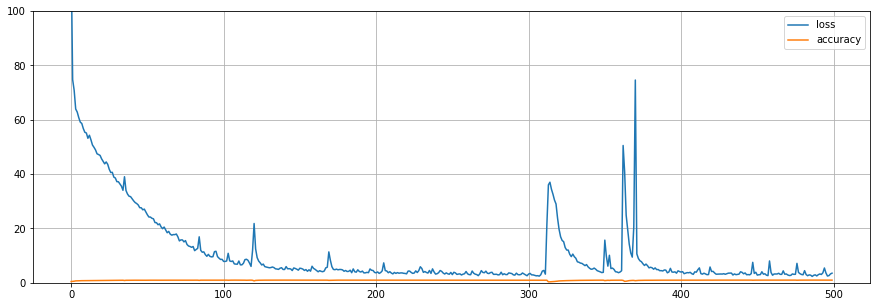

In [29]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

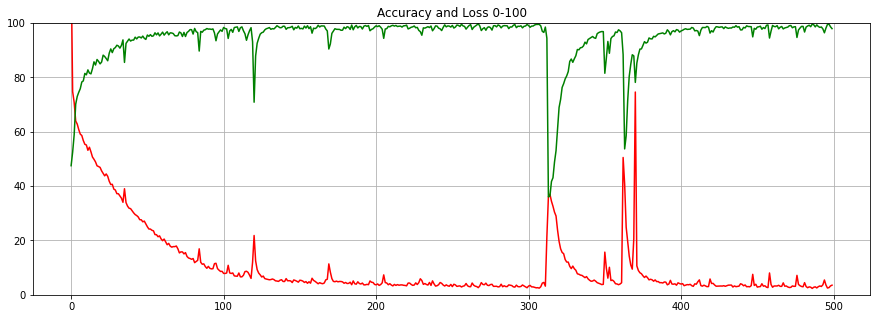

In [30]:
plt.rcParams['figure.figsize']=(15,5)
plt.plot(hist.history['loss'],color='red')
plt.plot(np.array(hist.history['accuracy'])*100,color='green')
plt.title('Accuracy and Loss 0-100')
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

In [31]:
BI_Based_SE_Architecture_3.evaluate(
          test_images,
  TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
        )

9/9 [==============================] - 1s 39ms/step - loss: 15.9010 - accuracy: 0.9167


[15.900980949401855, 0.9166666865348816]

## Bayesian Squeeze and Excitation Learning with Exact KL Divergence

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=tfp.layers.Convolution2DReparameterization(filters=128, kernel_size=16, activation='relu',
        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = Exact_divergence_fn,
        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
        bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn = Exact_divergence_fn)(Input_)

padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(padding_1,128)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(padding_2)
Attension_3=SE_BLOCK(Hidden_3,32)

Last_conv=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
padding_last=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Last_conv)

Flat=keras.layers.Flatten()(padding_last)

Dense_network=tfp.layers.DenseReparameterization(
    units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Exact_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Exact_divergence_fn)(Flat)
output_1=tfp.layers.OneHotCategorical(3)(Dense_network)

In [33]:
Exact_BI_Based_SE_Architecture_3=keras.models.Model([Input_],[output_1])

In [34]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))

Exact_BI_Based_SE_Architecture_3.compile(loss = negative_log_likelihood,
             optimizer = keras.optimizers.Adam(learning_rate=0.005),metrics = ['accuracy'])

In [35]:
hist=Exact_BI_Based_SE_Architecture_3.fit(
                   train_images,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values,
                   epochs=300)

Epoch 1/300
88/88 [==============================] - 9s 59ms/step - loss: 111.3782 - accuracy: 0.5225
Epoch 2/300
88/88 [==============================] - 5s 57ms/step - loss: 70.2065 - accuracy: 0.6157
Epoch 3/300
88/88 [==============================] - 4s 49ms/step - loss: 67.9952 - accuracy: 0.6371
Epoch 4/300
88/88 [==============================] - 4s 49ms/step - loss: 65.7608 - accuracy: 0.6700
Epoch 5/300
88/88 [==============================] - 4s 49ms/step - loss: 62.7918 - accuracy: 0.7104
Epoch 6/300
88/88 [==============================] - 4s 50ms/step - loss: 58.6310 - accuracy: 0.7714
Epoch 7/300
88/88 [==============================] - 4s 50ms/step - loss: 57.3617 - accuracy: 0.7946
Epoch 8/300
88/88 [==============================] - 5s 58ms/step - loss: 56.0569 - accuracy: 0.8075
Epoch 9/300
88/88 [==============================] - 5s 55ms/step - loss: 54.2924 - accuracy: 0.8239
Epoch 10/300
88/88 [==============================] - 4s 49ms/step - loss: 55.3331 - accur

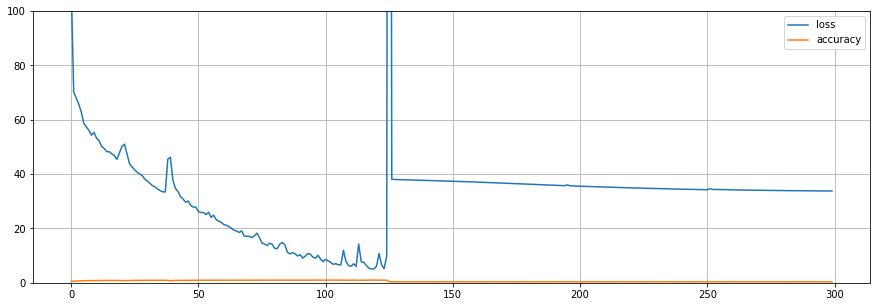

In [36]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

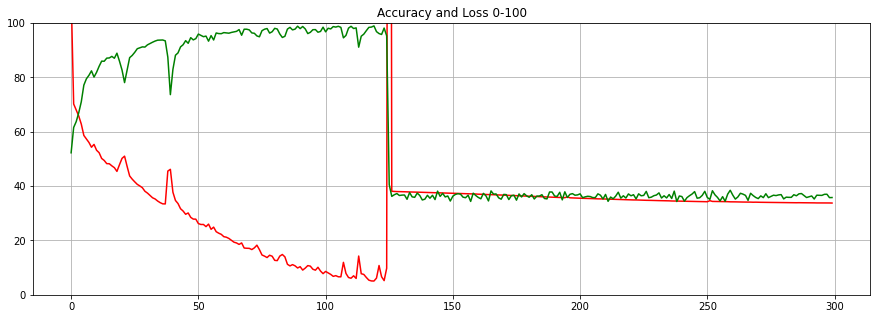

In [37]:
plt.rcParams['figure.figsize']=(15,5)
plt.plot(hist.history['loss'],color='red')
plt.plot(np.array(hist.history['accuracy'])*100,color='green')
plt.title('Accuracy and Loss 0-100')
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

In [38]:
BI_Based_SE_Architecture_3.evaluate(
          test_images,
  TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
        )

9/9 [==============================] - 0s 26ms/step - loss: 13.7428 - accuracy: 0.9091


[13.742776870727539, 0.9090909361839294]

## Variational AutoEncoder For Mask Reconstruction



In [103]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,1)),
      keras.layers.Conv2D(32,(3,3),padding='same'),
      keras.layers.AveragePooling2D(),
      keras.layers.Conv2D(16,(3,3),padding='same'),
      keras.layers.AveragePooling2D(),
      keras.layers.Conv2D(8,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(4),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.
                                    MultivariateNormalDiag(loc=t[...,:2],
                                            scale_diag=tf.math.softplus(t[...,2:])))
])
Decoder=keras.models.Sequential([
                    keras.layers.Input(shape=[2]),
  keras.layers.Dense(128),keras.layers.Reshape((4,4,8)),keras.layers.Conv2DTranspose(16,(3,3)),
keras.layers.UpSampling2D(),keras.layers.Conv2DTranspose(32,(3,3)),keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.UpSampling2D(),
              keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.UpSampling2D(),
          keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.Conv2DTranspose(1,(3,3)),
                              keras.layers.Flatten(),
                    tfp.layers.IndependentBernoulli((128,128,1))
])

In [104]:
Prior_distribution=tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(2))

In [105]:
def LOSS(data,posterior_dist,Prior_distribution,preds):
  return tf.reduce_sum(tfp.distributions.kl_divergence(posterior_dist,
                                               Prior_distribution)-preds.log_prob(data))
def calculate_Gradient_losses(data):
  with tf.GradientTape() as Tape:
    Tape.watch(Encoder.trainable_variables+Decoder.trainable_variables)
    posterior_dist=Encoder(data)
    preds=Decoder(posterior_dist.sample())
    Loss=LOSS(data,posterior_dist,Prior_distribution,preds)
    grads=Tape.gradient(Loss,Encoder.trainable_variables+Decoder.trainable_variables)
  return Loss,grads

In [106]:
optimizer=keras.optimizers.Adam(learning_rate=0.005)

In [107]:
train_masks_batched=tf.data.Dataset.from_tensor_slices(train_masks).batch(128)

In [108]:
losses=[]
for epoch in range(100):
  for batch in train_masks_batched:
    loss,grad=calculate_Gradient_losses(batch)
    optimizer.apply_gradients(zip(grad,Encoder.trainable_variables + Decoder.trainable_variables))
  print(f'Epoch : {epoch+1} Loss : {loss}')
  losses.append(loss)

Epoch : 1 Loss : 183142.921875
Epoch : 2 Loss : 114538.5
Epoch : 3 Loss : 87177.90625
Epoch : 4 Loss : 80886.796875
Epoch : 5 Loss : 79050.4375
Epoch : 6 Loss : 82975.828125
Epoch : 7 Loss : 77063.2890625
Epoch : 8 Loss : 78102.796875
Epoch : 9 Loss : 76855.953125
Epoch : 10 Loss : 76547.6484375
Epoch : 11 Loss : 75319.921875
Epoch : 12 Loss : 74662.078125
Epoch : 13 Loss : 75985.2578125
Epoch : 14 Loss : 74048.0
Epoch : 15 Loss : 74487.2265625
Epoch : 16 Loss : 75142.421875
Epoch : 17 Loss : 74174.6015625
Epoch : 18 Loss : 80684.6328125
Epoch : 19 Loss : 74416.9140625
Epoch : 20 Loss : 73600.5
Epoch : 21 Loss : 73665.40625
Epoch : 22 Loss : 73623.9765625
Epoch : 23 Loss : 74393.671875
Epoch : 24 Loss : 74233.6875
Epoch : 25 Loss : 73115.9375
Epoch : 26 Loss : 72978.984375
Epoch : 27 Loss : 72855.1875
Epoch : 28 Loss : 73220.1953125
Epoch : 29 Loss : 72790.65625
Epoch : 30 Loss : 72713.8984375
Epoch : 31 Loss : 73796.953125
Epoch : 32 Loss : 76230.6875
Epoch : 33 Loss : 84942.3203125
E

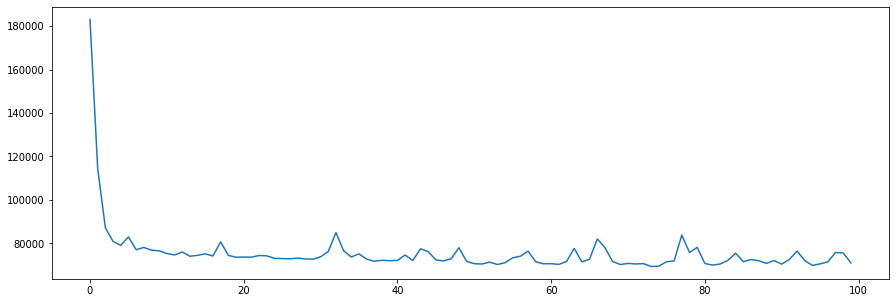

In [109]:
plt.plot(losses)

In [110]:
preds=Decoder(Encoder(test_masks))

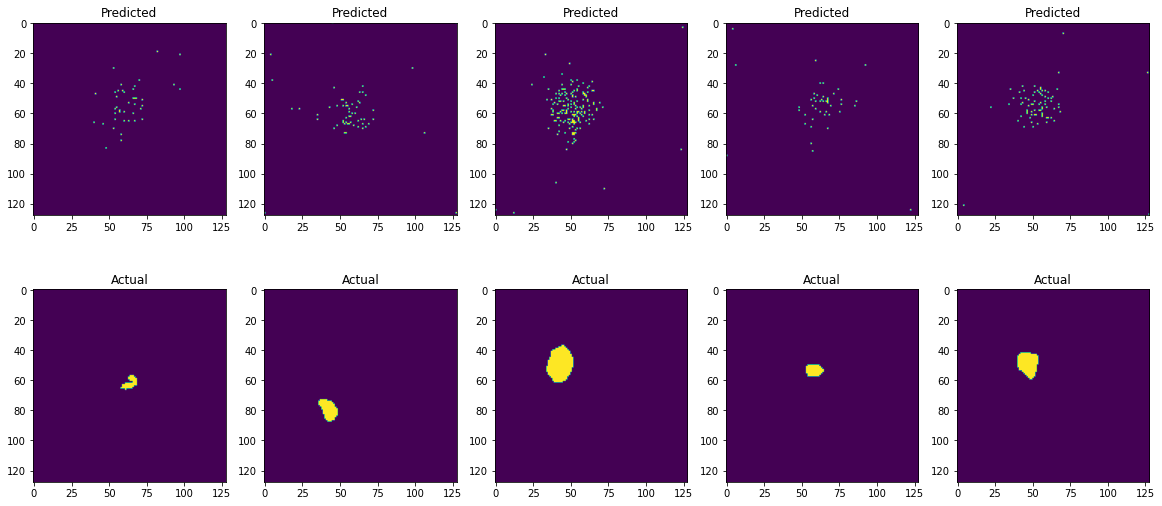

In [121]:
plt.rcParams['figure.figsize']=(20,9)
for i in range(5):
  try:
    plt.subplot(2,5,i+1)
    plt.imshow(np.array(preds[i]).reshape(128,128))
    plt.title('Predicted')
    plt.subplot(2,5,i+6)
    plt.imshow(test_masks[i].reshape(128,128))
    plt.title('Actual')
  except:
    pass
plt.show()

## Simple AutoEncoder

In [7]:
Encoder_=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,1)),
      keras.layers.Conv2D(32,(3,3),padding='same'),
      keras.layers.AveragePooling2D(),
      keras.layers.Conv2D(16,(3,3),padding='same'),
      keras.layers.AveragePooling2D(),
      keras.layers.Conv2D(8,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(2)
])
Decoder_=keras.models.Sequential([
                    keras.layers.Input(shape=[2]),
  keras.layers.Dense(128),keras.layers.Reshape((4,4,8)),keras.layers.Conv2DTranspose(16,(3,3)),
keras.layers.UpSampling2D(),keras.layers.Conv2DTranspose(32,(3,3)),keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.UpSampling2D(),
              keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.UpSampling2D(),
 keras.layers.Conv2DTranspose(8,(3,3)),keras.layers.Conv2DTranspose(1,(3,3),activation='sigmoid')
                              
])

In [8]:
AUTOENCODER=keras.models.Model([Encoder_.input],[Decoder_(Encoder_.output)])

In [9]:
AUTOENCODER.compile(optimizer='Adam',loss='mse')
AUTOENCODER.fit(train_images,train_masks,epochs=2)

Epoch 1/2
88/88 [==============================] - 75s 822ms/step - loss: 0.0473
Epoch 2/2
88/88 [==============================] - 68s 776ms/step - loss: 0.0174


In [ ]:
plt.rcParams['figure.figsize']=(12,5)
encoded=Encoder_.predict(test_images)
plt.scatter(encoded[:,0],encoded[:,1])
plt.show()

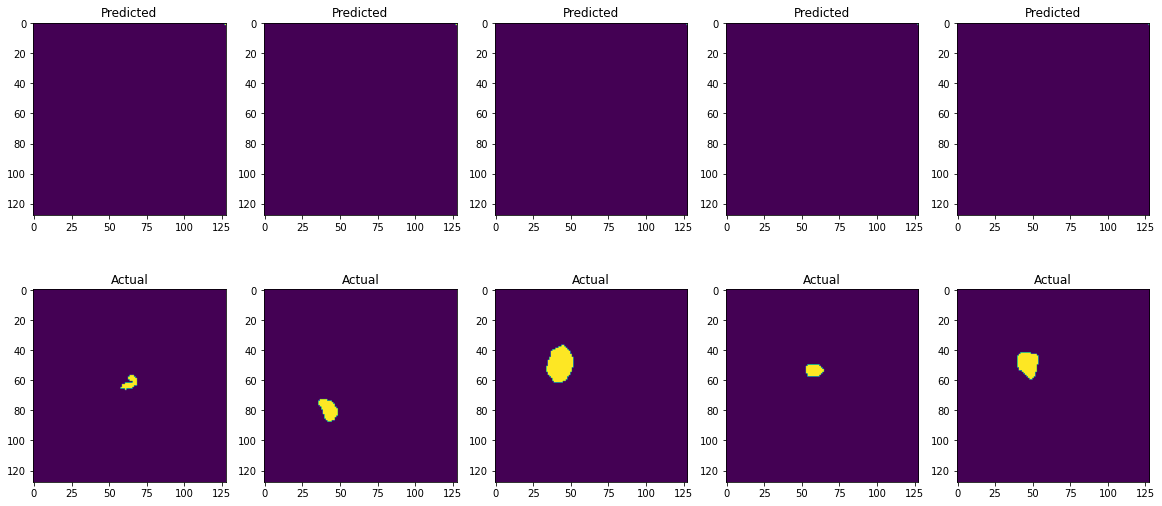

In [14]:
pred_=AUTOENCODER.predict(test_images)
plt.rcParams['figure.figsize']=(20,9)
for i in range(5):
  try:
    plt.subplot(2,5,i+1)
    plt.imshow(np.round(np.array(pred_[i]).reshape(128,128)))
    plt.title('Predicted')
    plt.subplot(2,5,i+6)
    plt.imshow(test_masks[i].reshape(128,128))
    plt.title('Actual')
  except:
    pass
plt.show()